# Deep Learning -BiLSTM

In [ ]:
!pip install gensim

import os
import pandas as pd
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

from gensim.models import KeyedVectors
from gensim.downloader import load as gensim_load

from sklearn.metrics import confusion_matrix, classification_report

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 36.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Load the dataset
df = pd.read_csv("/content/Social Media Engagement Dataset.csv")

In [ ]:
# Drop the unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (8059, 28)


In [ ]:
# Check the distribution of 'status' before resampling
print("\nStatus Value Counts before resampling:")
print(df['sentiment_label'].value_counts())



Status Value Counts before resampling:
sentiment_label
Positive    3283
Negative    3266
Neutral     1510
Name: count, dtype: int64


In [ ]:
#  Resampling to Balance Classes
def resample_data(df):
    max_count = df['sentiment_label'].value_counts().max()
    df_resampled = pd.DataFrame()
    for sentiment_label in df['sentiment_label'].unique():
        df_class = df[df['sentiment_label'] == sentiment_label]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_data(df)
print("Value counts after resampling:")
print(df['sentiment_label'].value_counts())

Value counts after resampling:
sentiment_label
Negative    3283
Positive    3283
Neutral     3283
Name: count, dtype: int64


In [ ]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['text_content'] = df['text_content'].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df['text_content'].head())


Sample preprocessed text:
11673    anyone tip google pixel watch trendsetter bran...
3178     unboxed new eero wifi amazon worth money sure ...
4786     unboxed new apple watch apple disappointed qua...
4199     unboxed new ultraboost adidas issue confused d...
4103     frustrated new air jordan nike returning asap ...
Name: text_content, dtype: object


In [ ]:
# Splitting Data and Encoding Labels
X = df['text_content'].values
y = df['sentiment_label'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (7879,) (7879, 3)
Testing set shape: (1970,) (1970, 3)


In [ ]:
# Tokenization and Padding
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Training Data Shape:", X_train_padded.shape)
print("Padded Testing Data Shape:", X_test_padded.shape)

Padded Training Data Shape: (7879, 100)
Padded Testing Data Shape: (1970, 100)


In [ ]:
# Loading Pre-trained Word2Vec via Gensim Downloader
print("Downloading the pre-trained Google News Word2Vec model. This may take a while...")
word2vec_model = gensim_load("word2vec-google-news-300")
embedding_dim = word2vec_model.vector_size
print("Download complete. Embedding dimension:", embedding_dim)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Download complete. Embedding dimension: 300


In [ ]:
# Building the Embedding Matrix with Fine-Tuning Enabled
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_count = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found_count += 1
    else:
        # Initialize missing words with random vectors
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Found embeddings for {found_count} out of {num_words} words.")

Found embeddings for 221 out of 278 words.


In [ ]:
# Building the BiLSTM Model (with Fine-Tuning)
lstm_units = 64
num_classes = y_categorical.shape[1]

model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              input_length=max_sequence_length,
              weights=[embedding_matrix],
              trainable=True),  # Now set to True for fine-tuning
    Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │        83,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,400 (325.78 KB)

 Trainable params: 83,400 (325.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the Model
history = model.fit(X_train_padded, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_test_padded, y_test))

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4701 - loss: 1.0108 - val_accuracy: 0.8970 - val_loss: 0.2426
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 59s 944ms/step - accuracy: 0.9127 - loss: 0.2199 - val_accuracy: 0.9431 - val_loss: 0.1260
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 61s 988ms/step - accuracy: 0.9473 - loss: 0.1256 - val_accuracy: 0.9497 - val_loss: 0.1062
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 62s 995ms/step - accuracy: 0.9538 - loss: 0.1069 - val_accuracy: 0.9492 - val_loss: 0.1005
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 978ms/step - accuracy: 0.9575 - loss: 0.0938 - val_accuracy: 0.9533 - val_loss: 0.1000
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9574 - loss: 0.0943 - val_accuracy: 0.9538 - val_loss: 0.0986
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 61s 981ms/step - accuracy: 0.9619 - loss: 0.0881 - val_accuracy: 0.9553 - val_loss: 0.0974
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 62s 999ms/step - accuracy: 0.9646 - loss: 0.0811 - val_accuracy: 

In [ ]:
# Evaluating the Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9530 - loss: 0.1026

Test Accuracy: 95.69%


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step
Confusion Matrix:
[[617  13  29]
 [  3 647  12]
 [ 13  15 621]]


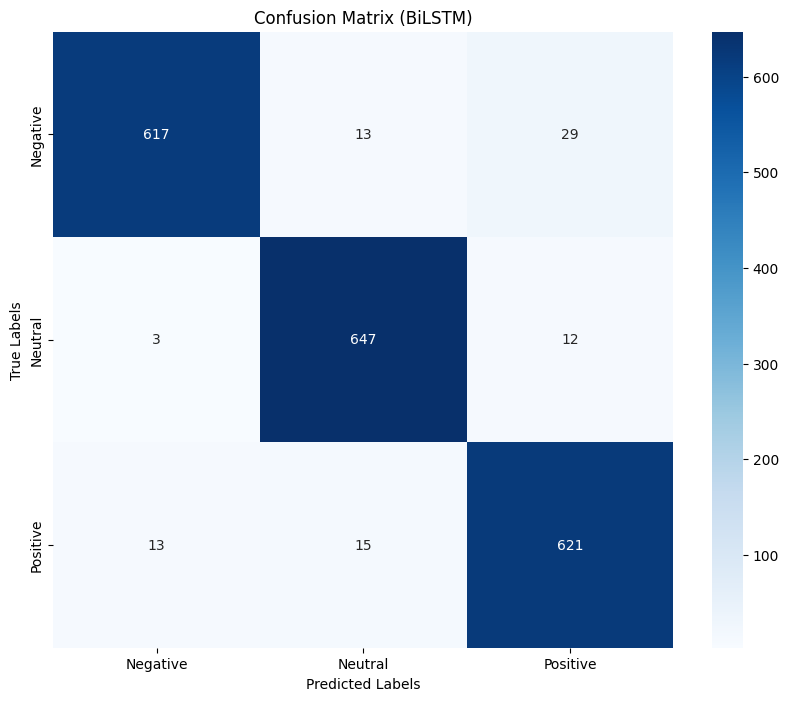

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9747    0.9363    0.9551       659
     Neutral     0.9585    0.9773    0.9678       662
    Positive     0.9381    0.9569    0.9474       649

    accuracy                         0.9569      1970
   macro avg     0.9571    0.9568    0.9568      1970
weighted avg     0.9572    0.9569    0.9568      1970



In [ ]:
# Generating Predictions and Evaluation Metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BiLSTM)')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

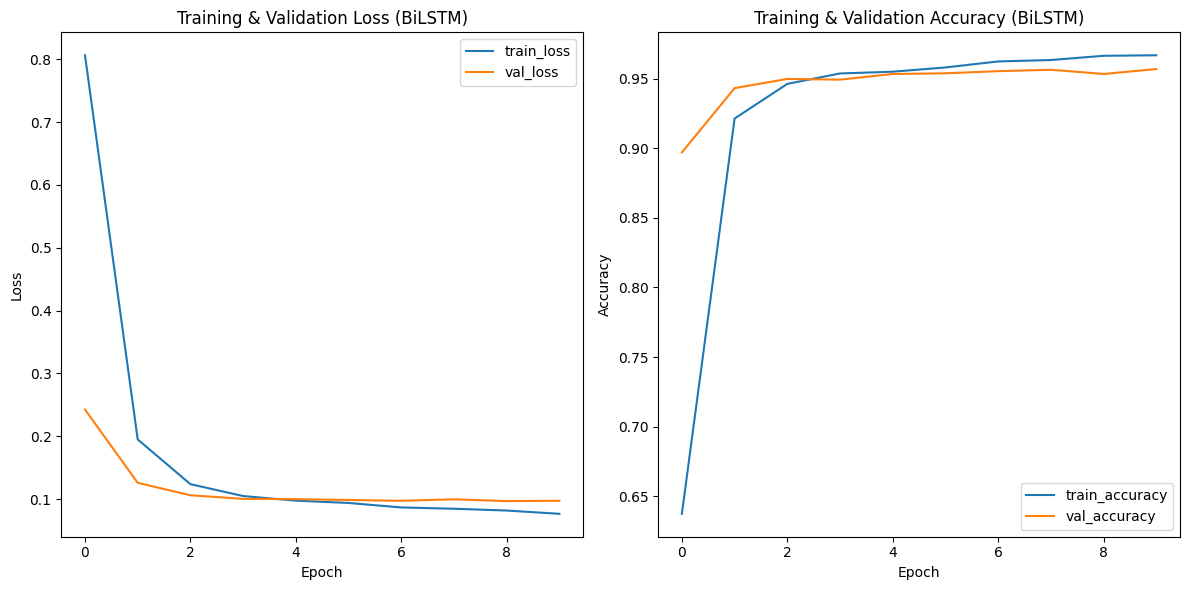

In [ ]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

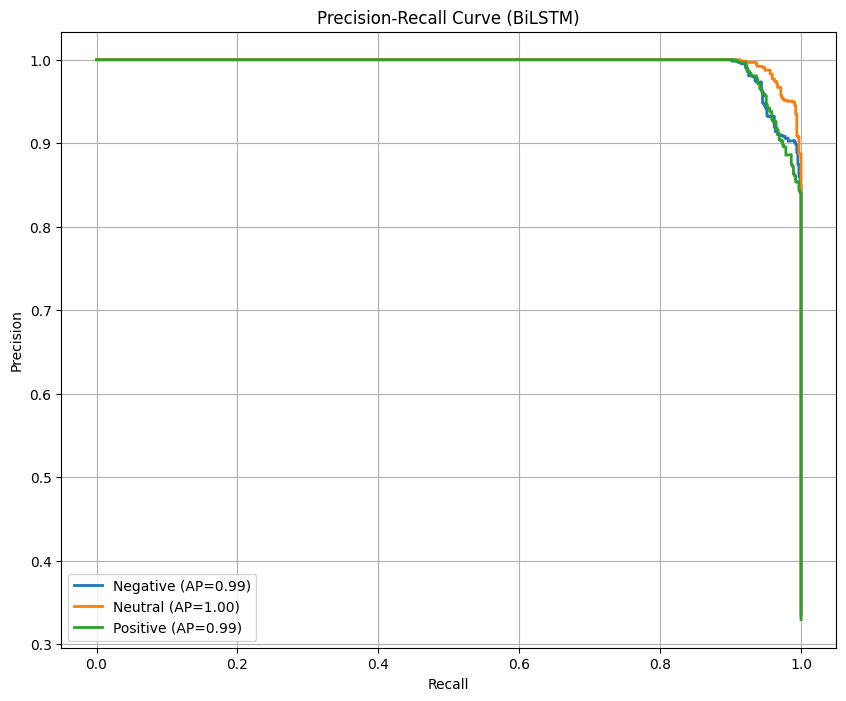

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class PR curve
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))
precision = dict()
recall = dict()
avg_precision = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{label_encoder.classes_[i]} (AP={avg_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (BiLSTM)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


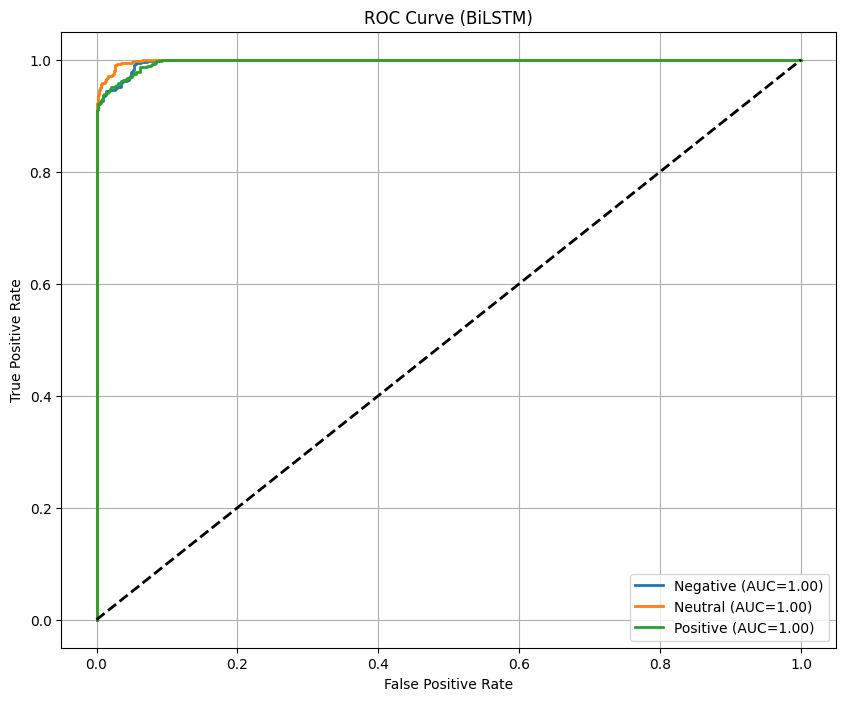

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.classes_[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (BiLSTM)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

